## Import libraries

In [2]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from models import customLogisticRegression
from parameters import ParameterProxy
from lib2 import valid_ifthens_with_coverage_correctness, rules2rulesbyif
import lib2
from formatting import recourse_report_reverse

import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [3]:
DATAFILE = '../ad_campaign_data.csv' # location of dataset
random_state = None # change to something for exactly reproducible results

# as selected in "tutorial_bias_advertising" notebook
selected_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
cate_features = ['gender', 'parents', 'age', 'income', 'area', 'college_educated']
num_features = ['homeowner']

# if not specified, set to 1
feature_weights = {"gender": 1, "parents": 1, "age": 1}

target_name = "true_conversion"
positive_label = 1
negative_label = 0

model_train_fraction = 0.7
learning_class_weights = {0: 0.5, 1: 265}

sensitive_attribute = "gender"

## Load Dataset

In [4]:
ad_conversion_dataset = pd.read_csv(DATAFILE)
ad_conversion_dataset.head()

,religion,politics,college_educated,parents,homeowner,gender,age,income,area,true_conversion,predicted_conversion,predicted_probability
0,Unknown,Unknown,1,1,1,Unknown,55-64,Unknown,Unknown,0,0,0.001351
1,Other,Unknown,1,1,1,Unknown,55-64,Unknown,Urban,0,0,0.002238
2,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.002704
3,Unknown,Unknown,1,1,1,F,55-64,Unknown,Unknown,0,0,0.001967
4,Unknown,Unknown,1,1,1,F,55-64,Unknown,Urban,0,0,0.001681


### Print some statistics for the dataset

In [5]:
print(f"Number of (instances, attributes) in the dataset = {ad_conversion_dataset.shape}")
print()

print(f"Statistics of true conversions (0=no, 1=yes)")
print(ad_conversion_dataset.true_conversion.value_counts())
print()

print(f"Statistics of predicted conversions (0=no, 1=yes)")
print(ad_conversion_dataset.predicted_conversion.value_counts())

Number of (instances, attributes) in the dataset = (1443140, 12)

Statistics of true conversions (0=no, 1=yes)
0    1440766
1       2374
Name: true_conversion, dtype: int64

Statistics of predicted conversions (0=no, 1=yes)
0    1440773
1       2367
Name: predicted_conversion, dtype: int64


### Warning!

There is no model!

Predictions (from whatever model has been used) have been incorporated into the dataset, in the columns "predicted_conversion" (which is the predicted label) and "predicted_probability" (which is the predicted probability of belonging to the positive class).

Moreover, the dataset is highly unbalanced, and this is also evident in the poor efficiency of the model, as demonstrated in the confusion matrix below.

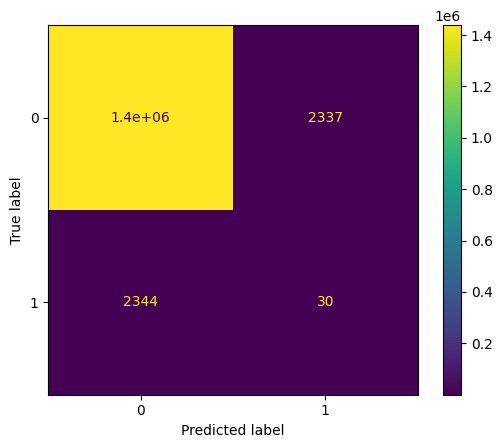

In [6]:
conf_matrix = confusion_matrix(ad_conversion_dataset.true_conversion, ad_conversion_dataset.predicted_conversion)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Preprocessing

In [7]:
## keep only the columns in selected_features, plus the label column
ad_conversion_dataset = ad_conversion_dataset[selected_features + [target_name]]
ad_conversion_dataset

,gender,parents,age,income,area,college_educated,homeowner,true_conversion
0,Unknown,1,55-64,Unknown,Unknown,1,1,0
1,Unknown,1,55-64,Unknown,Urban,1,1,0
2,F,1,55-64,Unknown,Unknown,1,1,0
3,F,1,55-64,Unknown,Unknown,1,1,0
4,F,1,55-64,Unknown,Urban,1,1,0
...,...,...,...,...,...,...,...,...
1443135,F,1,25-34,Unknown,Unknown,1,1,0
1443136,F,1,55-64,Unknown,Unknown,1,0,0
1443137,Unknown,1,55-64,Unknown,Unknown,1,1,0
1443138,F,1,55-64,Unknown,Unknown,1,1,0


In [8]:
## train-test split

X = ad_conversion_dataset.drop(target_name, axis=1)
y = ad_conversion_dataset[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=model_train_fraction, random_state=random_state, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Model training

In [9]:
%%time

model = customLogisticRegression(class_weight=learning_class_weights)
model.fit(X_train, y_train, cate_columns=cate_features, target_column=target_name)
model.predict(X_test.iloc[:100, :])

CPU times: total: 10.1 s
Wall time: 8.32 s


array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# Testing the model

We check if the model is satisfactory.

In [10]:
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       1.00      0.90      0.95    432231
           1       0.00      0.12      0.00       712

    accuracy                           0.90    432943
   macro avg       0.50      0.51      0.48    432943
weighted avg       1.00      0.90      0.95    432943



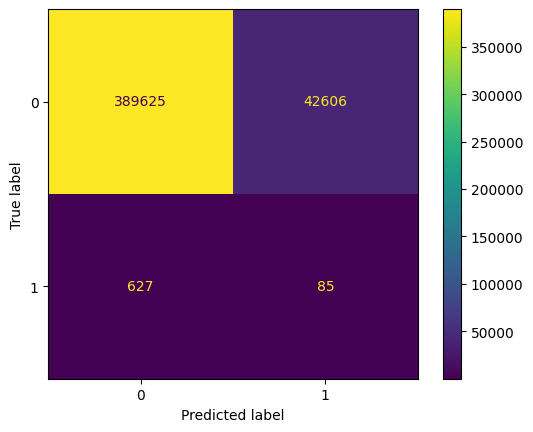

In [11]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

Given the high imbalance of the dataset, we consider that the above results, for a simple logistic regression, are good enough.

# Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [12]:
# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model,
#     sensitive_attribute
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Uncomment the following block if you wish to load rules object from disk.

In [13]:
import dill

with open("rules.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [14]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["M"][1][0][1]-e[1]["F"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(list(rules_by_if_filtered.items()), missing_subgroup_val="Unknown"))

If college_educated = 1, parents = 1, homeowner = 1, area = Unknown, age = 55-64, income = Unknown:
	Subgroup 'F', 51.0554% covered
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = <100K with correctness 0.0000%.
	Subgroup 'M', 57.4873% covered
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 100.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = <100K with correctness 100.0000%.
If college_educated = 1, parents = 1, homeowner = 1, age = 55-64, area = Rural, income = Unknown:
	Subgroup 'F', 3.9471% covered
		Make college_educated = 1, parents = 1, homeowner = 1, age = 45-54, area = Urban, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, age = 4

In [15]:
##### Uncomment if you wish to save rules object on disk

# import dill

# with open("rules.data", "wb") as outf:
#     dill.dump(rules_by_if, outf)

# Filter rules by different scoring functions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [16]:
K = 10

rules_max_costdiff_2groups = lib2.sort_triples_by_costdiff_2groups(rules_by_if, "M", "F")[:K]
rules_max_costdiff_2groups = dict(rules_max_costdiff_2groups)

print(recourse_report_reverse(
    list(rules_max_costdiff_2groups.items()),
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown"
))

If income = Unknown, homeowner = 1, area = Unknown, age = Unknown:
	Subgroup 'F', 1.7305% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness -0.0000%.
	Subgroup 'M', 1.9012% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 94.8520%.
If income = Unknown, homeowner = 1, area = Urban:
	Subgroup 'F', 21.4659% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown with correctness 1.6171%.
	Subgroup 'M', 22.6137% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown with correctness 91.1491%.
If college_educated = 1, parents = 1, homeowner = 1, area = Unknown, age = Unknown, income = Unknown:
	Subgroup 'F', 1.5458% covered out of 600135
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 5

# Generalize to arbitrary number of subgroups



In [24]:
rules_by_if_no_unknown = {ifc: {sg: thens for sg, thens in sg_thens.items() if sg != "Unknown"} for ifc, sg_thens in rules_by_if.items()}

In [25]:
comparators = lib2.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

In [26]:
rules_max_costdiff_sorted = lib2.sort_triples_by_max_costdiff(rules_by_if_no_unknown, params=params)

print(recourse_report_reverse(
    rules_max_costdiff_sorted[:K],
    population_sizes = {"M": (ad_conversion_dataset.gender == "M").sum(), "F": (ad_conversion_dataset.gender == "F").sum()},
    missing_subgroup_val="Unknown"
))

If income = Unknown, homeowner = 1, area = Unknown, age = Unknown:
	Subgroup 'F', 1.7305% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness -0.0000%.
	Subgroup 'M', 1.9012% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown, age = 55-64 with correctness 94.8520%.
If income = Unknown, homeowner = 1, area = Urban:
	Subgroup 'F', 21.4659% covered out of 600135
		Make income = <100K, homeowner = 0, area = Unknown with correctness 1.6171%.
	Subgroup 'M', 22.6137% covered out of 314181
		Make income = <100K, homeowner = 0, area = Unknown with correctness 91.1491%.
If college_educated = 1, parents = 1, homeowner = 1, area = Unknown, age = Unknown, income = Unknown:
	Subgroup 'F', 1.5458% covered out of 600135
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 55-64, income = Unknown with correctness 0.0000%.
		Make college_educated = 1, parents = 1, homeowner = 0, area = Unknown, age = 5

# Find fairness-oriented counterfactuals (the same as above) for all features as sensitive!

In [27]:
# all_attributes = ['gender', 'parents', 'age', 'income', 'area', 'college_educated', 'homeowner']
# rules = {attr: [] for attr in all_attributes}

# for attr in all_attributes:
#     print(f"Starting with attribute {attr} as sensitive")
#     rules[attr] = valid_ifthens_with_coverage_correctness(
#         X_test,
#         model,
#         sensitive_attribute=attr
#     )
#     prompt = input("Continue? (y/n) [y] ")
#     if prompt.startswith("n"):
#         break

# for attr in rules.keys():
#     rules[attr] = rules2rulesbyif(rules[attr])

Uncomment the following block if you wish to load rules object from disk.

In [28]:
import dill

with open("rules_all_attributes.data", "rb") as inf:
    rules = dill.load(inf)

Uncomment the following block if you wish to save rules object on disk.

In [29]:
# import dill

# with open("rules_all_attributes.data", "wb") as outf:
#     dill.dump(rules, outf)

# Filter rules by different scoring functions (again)

For now, for the attribute "age".

## For each if-group, inner product of then costs and correctness-es, divided by the number of terms

In [31]:
K = 10

rules_max_costdiff_sorted_age = lib2.sort_triples_by_max_costdiff(rules["gender"], params=params)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    rules_max_costdiff_sorted_age[:K],
    population_sizes = pop_sizes,
    missing_subgroup_val="Unknown"
))

If homeowner = 1, income = Unknown, parents = 1, age = Unknown, college_educated = 1, area = Unknown:
	Subgroup 'F', 1.5969% covered out of 600135
		Make homeowner = 0, income = Unknown, parents = 1, age = 45-54, college_educated = 1, area = Unknown with correctness 0.0000%.
	Subgroup 'M', 1.5153% covered out of 314181
		Make homeowner = 0, income = Unknown, parents = 1, age = 45-54, college_educated = 1, area = Unknown with correctness 0.0000%.
If homeowner = 1, parents = 1, age = Unknown, college_educated = 1, area = Unknown:
	Subgroup 'F', 1.6625% covered out of 600135
		Make homeowner = 0, parents = 1, age = 45-54, college_educated = 1, area = Unknown with correctness 1.7970%.
	Subgroup 'M', 1.5814% covered out of 314181
		Make homeowner = 0, parents = 1, age = 45-54, college_educated = 1, area = Unknown with correctness 1.2040%.
If homeowner = 1, income = Unknown, age = 25-34, college_educated = 1, area = Unknown:
	Subgroup 'F', 1.0579% covered out of 600135
		Make homeowner = 0, 

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

In [34]:
rules_gender_no_unknown = {ifclause: {sg: val for sg, val in thenclauses.items() if sg != "Unknown"} for ifclause, thenclauses in rules["gender"].items()}

In [35]:
rules_max_costdiff_sorted_age = lib2.sort_triples_by_max_costdiff_ignore_nans(
    rules_gender_no_unknown,
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    rules_max_costdiff_sorted_age[:K],
    population_sizes = pop_sizes
))

If parents = 1, income = <100K:
	Subgroup 'F', 2.8621% covered out of 600135
		Make parents = 1, income = >100K with correctness 51.0643%.
	Subgroup 'M', 2.7395% covered out of 314181
		Make parents = 1, income = >100K with correctness 49.9182%.
If area = Unknown, college_educated = 1, age = Unknown:
	Subgroup 'F', 2.0983% covered out of 600135
		Make area = Rural, college_educated = 1, age = Unknown with correctness 15.1591%.
	Subgroup 'M', 2.0249% covered out of 314181
		Make area = Rural, college_educated = 1, age = Unknown with correctness 90.6527%.
If area = Unknown, parents = 1, college_educated = 1, age = Unknown:
	Subgroup 'F', 1.9823% covered out of 600135
		Make area = Rural, parents = 1, college_educated = 1, age = Unknown with correctness 15.9279%.
	Subgroup 'M', 1.9107% covered out of 314181
		Make area = Rural, parents = 1, college_educated = 1, age = Unknown with correctness 95.9555%.
If area = Unknown, income = Unknown, college_educated = 1, age = Unknown:
	Subgroup 'F'

## For each if-group, minimum cost of change among thens that surpass a correctness threshold

Before, when, for a subgroup, there were no thens that surpassed the threshold, the minimum cost of change was valued as infinity, and thus, as it is evident in the results, the algorithm finds many rules for which some groups surpass the threshold and some groups do not (because for those rules the difference between maximum and minimum cost of the subgroups evaluates to infinity).

Here, the difference is that we will ignore altogether rules for which the correctness drops below the threshold for all recourses (for some subgroup), considering them as "empty".

In [25]:
rules_max_costdiff_sorted_age = lib2.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules["age"],
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.5
)

pop_sizes = {sg: (ad_conversion_dataset["age"] == sg).sum() for sg in ad_conversion_dataset["age"].unique()}
print(recourse_report_reverse(
    rules_max_costdiff_sorted_age[:K],
    population_sizes = pop_sizes
))

Dommage monsieur!
If college_educated = 1:
	Subgroup '18-24', 95.8057% covered out of 1456
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '25-34', 94.4200% covered out of 25849
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '45-54', 93.7537% covered out of 24711
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '55-64', 94.3824% covered out of 1350500
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup 'Unknown', 94.0747% covered out of 40624
		Make college_educated = 0 with correctness 0.0000%.
If income = Unknown:
	Subgroup '18-24', 94.9227% covered out of 1456
		Make income = >100K with correctness 0.0000%.
	Subgroup '25-34', 95.7840% covered out of 25849
		Make income = >100K with correctness 17.8654%.
	Subgroup '45-54', 95.8163% covered out of 24711
		Make income = >100K with correctness 30.0000%.
	Subgroup '55-64', 95.9620% covered out of 1350500
		Make income = >100K with correctness 31.3499%.
	Subgroup 'Unknown', 95.05

### Dommage monsieur!

As playfully pointed out by our comment, there does not seem to exist **any** rule for which all subgroups have at least one recourse that surpasses the correctness threshold of 50%.

It would appear that this is either because the threshold is too high, or because the age group '18-24' is very small and there does not seem to be any rule that achieves some correctness on that group.

Thus, we will further explore this in both directions: tuning the threshold value and trying on another attribute.

In [26]:
rules_max_costdiff_sorted_age = lib2.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules["age"],
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.001
)

pop_sizes = {sg: (ad_conversion_dataset["age"] == sg).sum() for sg in ad_conversion_dataset["age"].unique()}
print(recourse_report_reverse(
    rules_max_costdiff_sorted_age[:K],
    population_sizes = pop_sizes
))

Dommage monsieur!
If college_educated = 1:
	Subgroup '18-24', 95.8057% covered out of 1456
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '25-34', 94.4200% covered out of 25849
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '45-54', 93.7537% covered out of 24711
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup '55-64', 94.3824% covered out of 1350500
		Make college_educated = 0 with correctness 0.0000%.
	Subgroup 'Unknown', 94.0747% covered out of 40624
		Make college_educated = 0 with correctness 0.0000%.
If income = Unknown:
	Subgroup '18-24', 94.9227% covered out of 1456
		Make income = >100K with correctness 0.0000%.
	Subgroup '25-34', 95.7840% covered out of 25849
		Make income = >100K with correctness 17.8654%.
	Subgroup '45-54', 95.8163% covered out of 24711
		Make income = >100K with correctness 30.0000%.
	Subgroup '55-64', 95.9620% covered out of 1350500
		Make income = >100K with correctness 31.3499%.
	Subgroup 'Unknown', 95.05

Apparently, no value of the threshold other than 0 has a chance. Let us try with a different attribute.

In [38]:
rules_max_costdiff_sorted_college_educated = lib2.sort_triples_by_max_costdiff_ignore_nans_infs(
    rules_gender_no_unknown,
    params=params,
    group_calculator=lib2.if_group_cost_max_change_correctness_threshold,
    cor_thres=0.1
)

pop_sizes = {sg: (ad_conversion_dataset["gender"] == sg).sum() for sg in ad_conversion_dataset["gender"].unique()}
print(recourse_report_reverse(
    rules_max_costdiff_sorted_college_educated[:K],
    population_sizes = pop_sizes
))

If homeowner = 1, income = <100K:
	Subgroup 'F', 1.5974% covered out of 600135
		Make homeowner = 0, income = >100K with correctness 91.6758%.
		Make homeowner = 0, income = Unknown with correctness 9.8276%.
		Make homeowner = 1, income = >100K with correctness 9.0209%.
	Subgroup 'M', 1.5893% covered out of 314181
		Make homeowner = 0, income = >100K with correctness 90.9796%.
		Make homeowner = 0, income = Unknown with correctness 10.5708%.
		Make homeowner = 1, income = >100K with correctness 10.0775%.
If income = Unknown:
	Subgroup 'F', 95.8989% covered out of 600135
		Make income = >100K with correctness 30.1191%.
	Subgroup 'M', 96.0330% covered out of 314181
		Make income = >100K with correctness 30.2642%.
If income = Unknown, college_educated = 1:
	Subgroup 'F', 90.4658% covered out of 600135
		Make income = >100K, college_educated = 1 with correctness 31.3323%.
	Subgroup 'M', 90.7366% covered out of 314181
		Make income = >100K, college_educated = 1 with correctness 31.4000%.
If

Seems ok!